In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mne
from tqdm import tqdm 

In [3]:
raw = mne.io.read_raw_eeglab('sep_uwgr_prepro.set', preload=False)
events, event_id = mne.events_from_annotations(raw)

tmin = -0.05
tmax = 0.22

epochs = mne.Epochs(raw, events, event_id, tmin, tmax, baseline=None, preload=False)

Reading /data/hu_kamm/eeg_llm/sep_uwgr_prepro.fdt
Used Annotations descriptions: [np.str_('1')]


/tmp/ipykernel_1116128/2354897670.py:1: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  raw = mne.io.read_raw_eeglab('sep_uwgr_prepro.set', preload=False)


Not setting metadata
6038 matching events found
No baseline correction applied
0 projection items activated


In [4]:
data = epochs.get_data()
avg_data = epochs.average().data

Loading data for 6038 events and 554 original time points ...
0 bad epochs dropped


In [11]:
U, S, Vh = np.linalg.svd(avg_data, full_matrices=True)

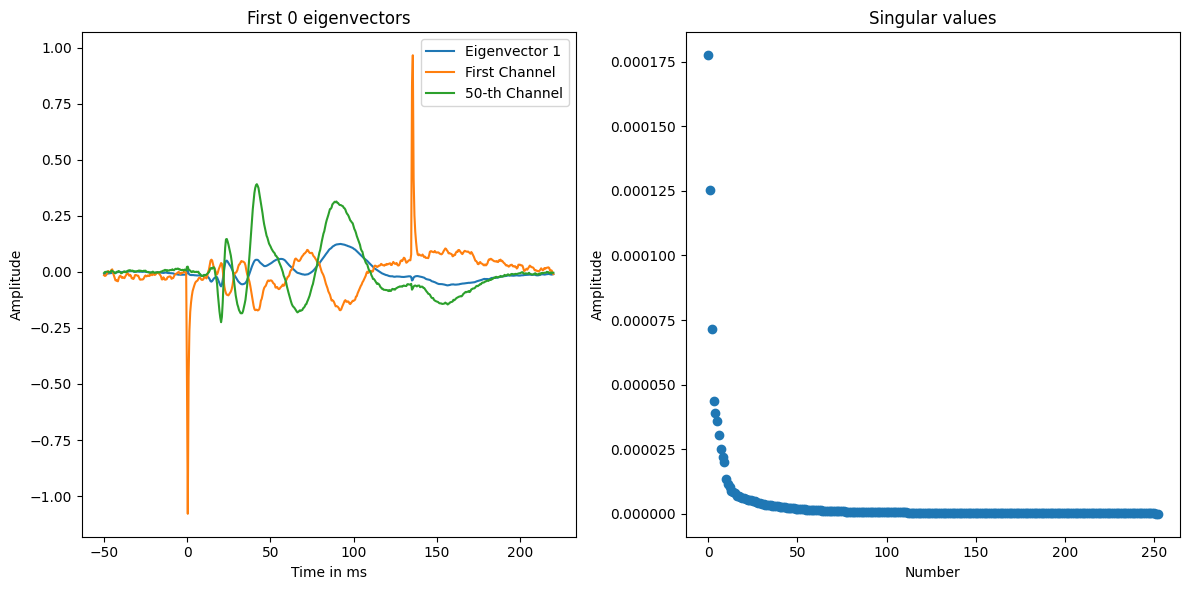

In [26]:
timepoints = np.linspace(tmin, tmax, 554)

# Create a figure with two subplots side-by-side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot on the first subplot
eig_n = 0

ax1.plot(timepoints * 1000, Vh[eig_n], label=f'Eigenvector {eig_n+1}')
ax1.plot(timepoints * 1000, avg_data[0] * 100000, label=f'First Channel')
ax1.plot(timepoints * 1000, avg_data[49] * 100000, label=f'50-th Channel')
ax1.set_title(f'First eigenvector')
ax1.set_xlabel('Time in ms')
ax1.set_ylabel('Amplitude')
ax1.legend()

# Plot on the second subplot
ax2.plot(S,'o')
ax2.set_title('Singular values')
ax2.set_xlabel('Number')
ax2.set_ylabel('Amplitude')

# Display the plots
plt.tight_layout()
plt.show()

In [46]:
data_reshaped = data.reshape((3345052, 545))

In [57]:
proj_U1 = np.dot(U[:, 0], data_reshaped.T)
proj_U2 = np.dot(U[:, 1], data_reshaped.T)

In [65]:
Vh[:, 0].shape

(554,)

In [ ]:
proj_V1 = np.dot(Vh[:, 0], )
proj_V1 = np.dot(Vh[:, 0], )

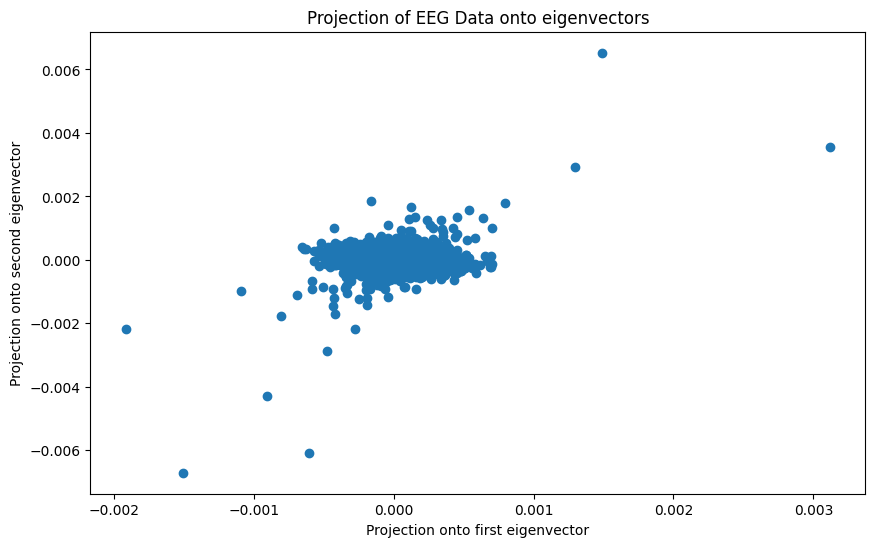

In [49]:
# data is more elongated around first eigenvector
plt.figure(figsize=(10, 6))
plt.scatter(proj_U1, proj_U2)
plt.xlabel('Projection onto first eigenvector')
plt.ylabel('Projection onto second eigenvector')
plt.title('Projection of EEG Data onto eigenvectors')
plt.show()

In [61]:
proj_U1 = np.dot(U.T[0], data)
proj_U2 = np.dot(U.T[1], data)

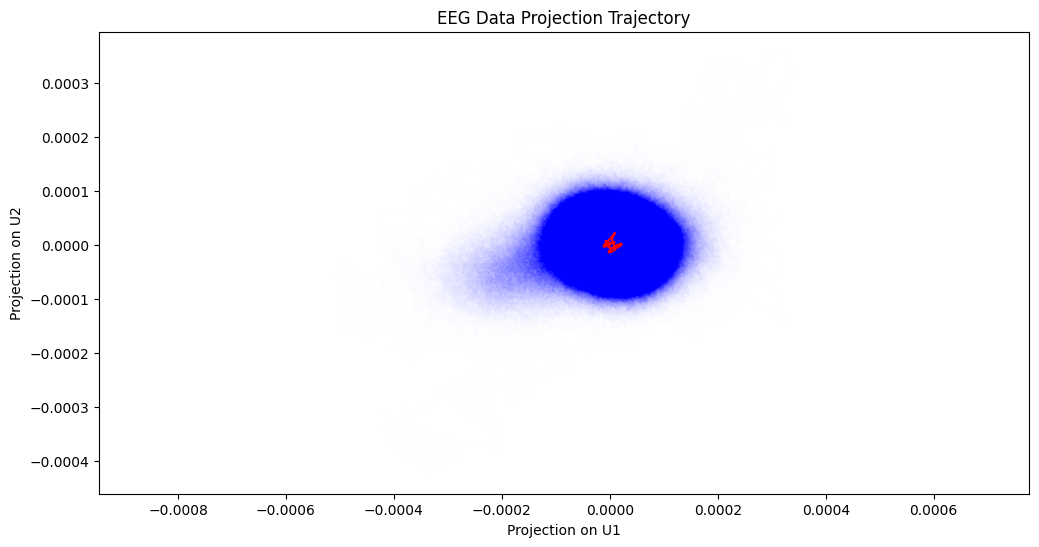

In [62]:
# Plot the trajectory (proj_U1 vs proj_U2)
plt.figure(figsize=(12, 6))
for trial_U1, trial_U2 in zip(proj_U1, proj_U2):
    plt.plot(trial_U1, trial_U2, alpha=0.002, color='blue')  # Each trial

plt.plot(S[0]*Vh[0], S[1]*Vh[1], color='red')

# Add labels and title
plt.xlabel('Projection on U1')
plt.ylabel('Projection on U2')
plt.title('EEG Data Projection Trajectory')

# Show the plot
plt.axis('equal')
plt.show()

In [ ]:
timepoints = np.linspace(tmin, tmax, 253)

# Create a figure with two subplots side-by-side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot on the first subplot
eig_n = 0

ax1.plot(timepoints * 1000, Vh[eig_n], label=f'Eigenvector {eig_n+1}')
ax1.plot(timepoints * 1000, avg_data[0] * 100000, label=f'First Channel')
ax1.plot(timepoints * 1000, avg_data[49] * 100000, label=f'50-th Channel')
ax1.set_title(f'First eigenvector')
ax1.set_xlabel('Time in ms')
ax1.set_ylabel('Amplitude')
ax1.legend()

# Plot on the second subplot
ax2.plot(S,'o')
ax2.set_title('Singular values')
ax2.set_xlabel('Number')
ax2.set_ylabel('Amplitude')

# Display the plots
plt.tight_layout()
plt.show()